In [1]:
# author: Zhuocheng Sun, Yueyu Wang
# instructor: Tyler Caraza-Harter

from shapely.geometry import Point, Polygon
import shapefile as shp
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import contextily as ctx
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [6]:
df = pd.read_csv("apartments.csv")
pts_col = []
for pt in df[["XCoord", "YCoord"]].itertuples():
    pts_col.append(Point(pt.XCoord, pt.YCoord))
df["geometry"] = pts_col
df = df[["Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry",
         "XCoord", "YCoord", "TotalLivingArea", "NetTaxes"]]
df = gpd.GeoDataFrame(df)
df = df.set_crs("esri:103412")
df = df.to_crs(epsg=4326)
df = df[["Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry",
         "XCoord", "YCoord", "TotalLivingArea", "NetTaxes"]]

/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (42,43,104,109,122) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [ ]:
residential = df[df["PropertyClass"] == "Residential"]
residential = residential[residential["PropertyUse"] != "Vacant"]
residential = residential[residential["PropertyUse"] != "Other"]
residential = residential[residential["PropertyUse"] != "Condominium-Notation"]
residential_0_bedroom = residential[residential["Bedrooms"] == 0]

residential_has_bedroom = residential[residential["Bedrooms"] != 0]
average_bedroom = residential_has_bedroom[["PropertyUse", "Bedrooms"]]
average_bedroom = average_bedroom.groupby("PropertyUse", as_index=False).mean()
average_bedroom["Bedrooms"] = round(average_bedroom["Bedrooms"])
average_bedroom["Bedrooms"] = average_bedroom["Bedrooms"].astype(int)
dict_average = dict(zip(average_bedroom['PropertyUse'],average_bedroom['Bedrooms']))
dict_average["3 To 7 Unit"] = 8
residential_0_bedroom = residential_0_bedroom.dropna()
def change_bedroom_for_0(df2):
    return dict_average[df2["PropertyUse"]]

residential_0_bedroom["Bedrooms"] = residential_0_bedroom.apply(lambda  r:change_bedroom_for_0(r), axis=1)
residential_0_bedroom = residential_0_bedroom[~residential_0_bedroom["Address"].str.contains("CDM")]

residential = pd.concat([residential_has_bedroom, residential_0_bedroom])

In [ ]:
commercial = df[df["PropertyClass"] == "Commercial"]
commercial['Apartment'] = commercial['PropertyUse'].str.contains("Apartment")
commercial = commercial[commercial["Apartment"] == True]
commercial = commercial.drop(columns= ["Apartment"])
commercial_unit = commercial[commercial["PropertyUse"].str.contains("unit")]

average_total =  residential_has_bedroom[["PropertyUse", "Bedrooms"]]
average_total = average_total[average_total["PropertyUse"] != "Single family"]
average_total = average_total["Bedrooms"]
average_bedrooms_for_commercial = int(average_total.mean())

def change_bedroom(df):
    return int(df["PropertyUse"][:-15]) * average_bedrooms_for_commercial
commercial_unit['Bedrooms']=commercial_unit.apply(lambda r:change_bedroom(r),axis=1)

In [16]:
commercial_others = commercial[~commercial["PropertyUse"].str.contains("unit")]

residential_bedroom_tax = residential[residential["PropertyUse"] != "Single family"][["Bedrooms", "NetTaxes"]]
tax_bedroom = dict(residential_bedroom_tax.sum())
tax_per_bedroom = tax_bedroom["NetTaxes"] / tax_bedroom["Bedrooms"]
def change_bedroom_for_other_commercial(df):
    return int(df["NetTaxes"] / tax_per_bedroom)

commercial_others["Bedrooms"] = commercial_others.apply(lambda  r:change_bedroom_for_other_commercial(r), axis=1)

frames = [commercial_unit, commercial_others]
commercial = pd.concat(frames)

frames = [commercial, residential]
df = pd.concat(frames)
df.head()


/opt/anaconda3/envs/CS_HW/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,TotalLivingArea,NetTaxes
22,2218 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45969 43.02980),800982.301653,466465.530860,0,7470.05
23,2218 Rosenberry Rd,8 unit Apartment,Commercial,24,POINT (-89.45839 43.02956),801330.016423,466379.037780,0,7470.05
332,2334 Talc Trl,40 unit Apartment,Commercial,120,POINT (-89.53268 43.02574),781462.275894,465004.129355,0,73883.80
510,813 N Thompson Dr,40 unit Apartment,Commercial,120,POINT (-89.29742 43.10858),844330.736065,495204.481640,0,94284.23
511,910 Rockefeller Ln,8 unit Apartment,Commercial,24,POINT (-89.29836 43.11047),844078.478226,495893.013690,0,21377.39


### Generally, 18 year-olds could be either 12th-grade students or college freshmen. Since we found many data entries with majorities of 18-19 year-olds, and many of those properties are located near UW campus, we think it makes more sense to regard them as college students rather than 12th-grade students. Thus, for simplicity, we only count 5 to 17 year-olds as K-12 student in this notebook.

In [17]:
census_df = pd.read_csv("census_by_block_2010/sex_age.csv")
census_df["GEO_ID"] = census_df["GEO_ID"]
census_df = census_df[["GEO_ID", "NAME", "P012001", "P012004", "P012005", "P012006", "P012028", "P012029", "P012030"]]
census_df = census_df.rename(columns = {"NAME":"Area", "P012001": "Total_people", "P012004": "5-9yrMale", "P012005": "10-14yrMale", "P012006": "15-17yrMale", "P012028": "5-9yrFemale", "P012029": "10-14yrFemale", "P012030": "15-17yrFemale"}, inplace=False)
census_df = census_df[1:]
census_df["Total_people"] = census_df["Total_people"].astype(int)
census_df["5-9yr"] = census_df["5-9yrMale"].astype(int) + census_df["5-9yrFemale"].astype(int)
census_df["10-14yr"] = census_df["10-14yrMale"].astype(int) + census_df["10-14yrFemale"].astype(int)
census_df["15-17yr"] = census_df["15-17yrMale"].astype(int) + census_df["15-17yrFemale"].astype(int)
census_df["Total_K-12_block"] = census_df["5-9yr"] + census_df["10-14yr"] + census_df["15-17yr"]
census_df = census_df[census_df["Total_K-12_block"] != 0]
census_df.head()

,GEO_ID,Area,Total_people,5-9yrMale,10-14yrMale,15-17yrMale,5-9yrFemale,10-14yrFemale,15-17yrFemale,5-9yr,10-14yr,15-17yr,Total_K-12_block
1,1000000US550250001001000,"Block 1000, Block Group 1, Census Tract 1, Dan...",170,1,3,1,1,7,4,2,10,5,17
2,1000000US550250001001001,"Block 1001, Block Group 1, Census Tract 1, Dan...",23,1,0,2,0,0,1,1,0,3,4
4,1000000US550250001001003,"Block 1003, Block Group 1, Census Tract 1, Dan...",38,1,1,0,0,1,3,1,2,3,6
5,1000000US550250001001004,"Block 1004, Block Group 1, Census Tract 1, Dan...",141,4,7,4,6,4,3,10,11,7,28
7,1000000US550250001001006,"Block 1006, Block Group 1, Census Tract 1, Dan...",38,1,0,3,0,6,0,1,6,3,10


In [18]:
# spatial join - take dataset A + dataset B = dataset AB, based on space/geographic relationship
# two datasets must have a matched CRS: coordinate reference system

dane = gpd.read_file("newdane/newdane.shp")

dane["GEO_ID"] = "1000000US" + dane["GEOID10"]
dane.head()

,STATEFP10,COUNTYFP10,TRACTCE10,BLOCKCE10,GEOID10,NAME10,MTFCC10,UR10,UACE10,UATYP10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,GEO_ID
0,55,025,000504,4022,550250005044022,Block 4022,G5040,U,53200,U,S,29724,0,+43.0201083,-089.5332753,"POLYGON ((-89.53341 43.02386, -89.53338 43.024...",1000000US550250005044022
1,55,025,011402,2035,550250114022035,Block 2035,G5040,U,53200,U,S,966914,0,+43.1459496,-089.2952544,"POLYGON ((-89.30400 43.15012, -89.29644 43.148...",1000000US550250114022035
2,55,025,011402,2055,550250114022055,Block 2055,G5040,U,53200,U,S,424,0,+43.1371818,-089.2960596,"POLYGON ((-89.29621 43.13719, -89.29602 43.137...",1000000US550250114022055
3,55,025,011401,3028,550250114013028,Block 3028,G5040,U,53200,U,S,27367,0,+43.0793222,-089.2820008,"POLYGON ((-89.28349 43.08452, -89.28278 43.082...",1000000US550250114013028
4,55,025,010901,1102,550250109011102,Block 1102,G5040,U,53200,U,S,23669,0,+43.0739416,-089.5306223,"POLYGON ((-89.53099 43.07488, -89.52984 43.074...",1000000US550250109011102


In [19]:
dane.to_crs(df.crs, inplace=True)
dane['area'] = dane.to_crs(epsg=3857).area/2.59e+06
block_with_apartment = gpd.sjoin(df, dane, how="left", op="within")
block_with_apartment = block_with_apartment[['Address', 'PropertyUse', 'PropertyClass', 'Bedrooms','geometry', "XCoord", "YCoord",  'GEO_ID', 'area']]
block_with_apartment.head()

,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,GEO_ID,area
22,2218 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45969 43.02980),800982.301653,466465.530860,1000000US550250006002000,0.039495
23,2218 Rosenberry Rd,8 unit Apartment,Commercial,24,POINT (-89.45839 43.02956),801330.016423,466379.037780,1000000US550250006002001,0.016105
332,2334 Talc Trl,40 unit Apartment,Commercial,120,POINT (-89.53268 43.02574),781462.275894,465004.129355,1000000US550250005044020,0.020012
510,813 N Thompson Dr,40 unit Apartment,Commercial,120,POINT (-89.29742 43.10858),844330.736065,495204.481640,1000000US550250026032068,0.009523
511,910 Rockefeller Ln,8 unit Apartment,Commercial,24,POINT (-89.29836 43.11047),844078.478226,495893.013690,1000000US550250026032059,0.017940


In [20]:
merged = pd.merge(block_with_apartment, census_df, on="GEO_ID", how='inner')
merged = merged[["Area","Address", "PropertyUse", "PropertyClass", "Bedrooms", "geometry", "XCoord", "YCoord", "Total_people", "Total_K-12_block", "GEO_ID", "area"]]
merged['BlockBedrooms'] = merged.groupby(['GEO_ID']).Bedrooms.transform('sum')
merged.head()

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms
0,"Block 2000, Block Group 2, Census Tract 6, Dan...",2218 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45969 43.02980),800982.301653,466465.530860,294,87,1000000US550250006002000,0.039495,354
1,"Block 2000, Block Group 2, Census Tract 6, Dan...",2322 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45995 43.02816),800912.471326,465869.120662,294,87,1000000US550250006002000,0.039495,354
2,"Block 2000, Block Group 2, Census Tract 6, Dan...",2306 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45986 43.02871),800935.774665,466068.197512,294,87,1000000US550250006002000,0.039495,354
3,"Block 2000, Block Group 2, Census Tract 6, Dan...",2226 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45973 43.02952),800970.644487,466366.051694,294,87,1000000US550250006002000,0.039495,354
4,"Block 2000, Block Group 2, Census Tract 6, Dan...",2234 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45978 43.02925),800959.021351,466267.246640,294,87,1000000US550250006002000,0.039495,354


In [21]:
import statsmodels.api as sm
target = merged['Total_K-12_block']
X = merged['BlockBedrooms']

model = sm.OLS(target, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:       Total_K-12_block   R-squared (uncentered):                   0.246
Model:                            OLS   Adj. R-squared (uncentered):              0.246
Method:                 Least Squares   F-statistic:                          2.098e+04
Date:                Sun, 31 Oct 2021   Prob (F-statistic):                        0.00
Time:                        21:16:01   Log-Likelihood:                     -2.9928e+05
No. Observations:               64322   AIC:                                  5.986e+05
Df Residuals:                   64321   BIC:                                  5.986e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
BlockBedrooms     0.0260      0.000    144.842      0.000       0.026       0.026
==============================================================================
Omnibus:                    20233.975   Durbin-Watson:                   0.019
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           117228.698
Skew:                           1.394   Prob(JB):                         0.00
Kurtosis:                       8.997   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
# merged["K12_est"] = merged["Total_K-12_block"] * merged["Bedrooms"] / merged["BlockBedrooms"]
K12_df = merged
K12_df.head()

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms
0,"Block 2000, Block Group 2, Census Tract 6, Dan...",2218 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45969 43.02980),800982.301653,466465.530860,294,87,1000000US550250006002000,0.039495,354
1,"Block 2000, Block Group 2, Census Tract 6, Dan...",2322 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45995 43.02816),800912.471326,465869.120662,294,87,1000000US550250006002000,0.039495,354
2,"Block 2000, Block Group 2, Census Tract 6, Dan...",2306 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45986 43.02871),800935.774665,466068.197512,294,87,1000000US550250006002000,0.039495,354
3,"Block 2000, Block Group 2, Census Tract 6, Dan...",2226 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45973 43.02952),800970.644487,466366.051694,294,87,1000000US550250006002000,0.039495,354
4,"Block 2000, Block Group 2, Census Tract 6, Dan...",2234 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45978 43.02925),800959.021351,466267.246640,294,87,1000000US550250006002000,0.039495,354


In [23]:
lake_df = gpd.read_file("lakes.zip")

Text(0.5, 1.0, 'Figure 1: Number of K-12 students in Madison per census block')

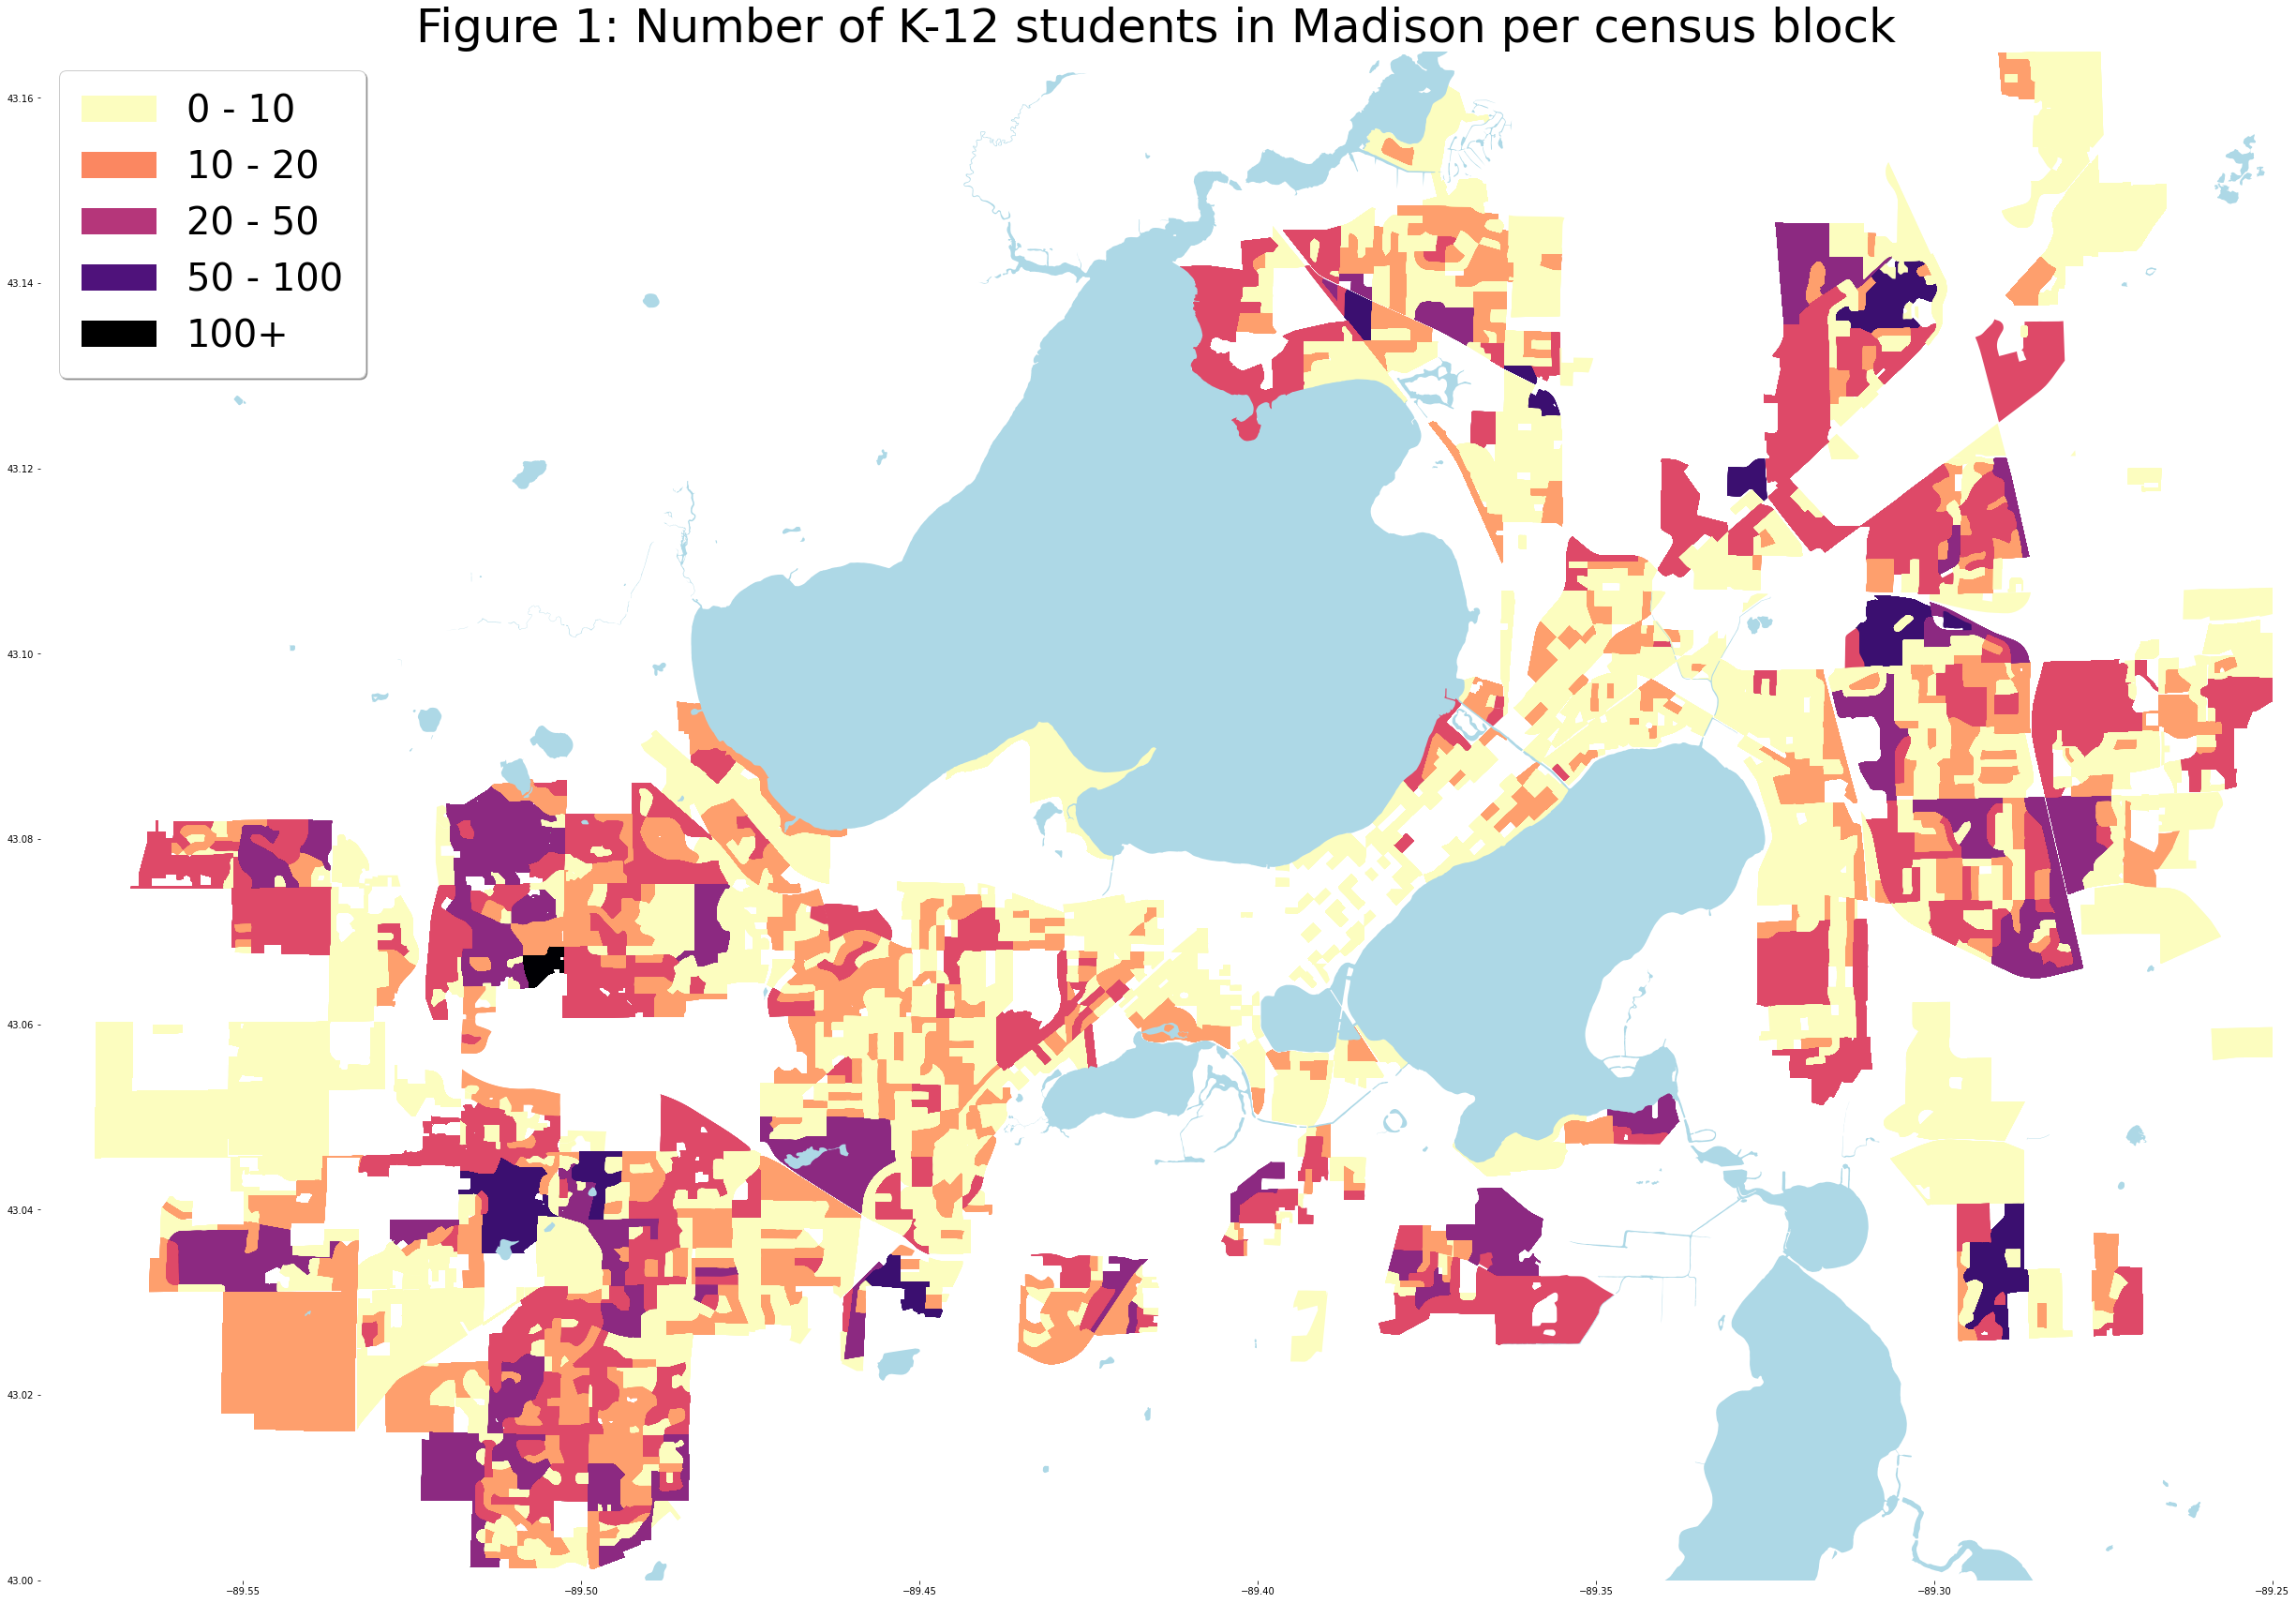

In [24]:
import matplotlib.patches as mpatches
import mapclassify as mc

madison = gpd.sjoin(K12_df, dane, how="right", op="within")
madison = madison[madison["Total_K-12_block"] >= 0]
bp = mc.UserDefined(madison["Total_K-12_block"], bins=[10, 20, 50, 100, 150])
ax = madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [10, 20, 50, 100, 150]},
                  k = 5, column='Total_K-12_block', cmap = 'magma_r')
lake_df.plot(ax=ax,color="lightblue")
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='100+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
# ax.axis('off')
ax.set_title("Figure 1: Number of K-12 students in Madison per census block", fontsize = 50)

## Linear Regression part

In [25]:
Condominium_bedroom_block = merged
Condominium_bedroom_block = Condominium_bedroom_block[Condominium_bedroom_block["PropertyUse"] != "2 Unit"]
Condominium_bedroom_block = Condominium_bedroom_block[Condominium_bedroom_block["PropertyUse"] != "Single family"]
Condominium_bedroom_block = Condominium_bedroom_block[Condominium_bedroom_block["PropertyUse"] != "3 To 7 Unit"]
Condominium_bedroom_block = Condominium_bedroom_block[["Area", "Address", "PropertyUse", "Bedrooms", "Total_K-12_block", "GEO_ID", "BlockBedrooms", "geometry", "area"]]
Condominium_bedroom_block["Apartment_bedroom"] = Condominium_bedroom_block.groupby(['GEO_ID']).Bedrooms.transform('sum')
Condominium_bedroom_block["Other_bedroom"] = Condominium_bedroom_block["BlockBedrooms"] - Condominium_bedroom_block["Apartment_bedroom"]
Condominium_bedroom_block = Condominium_bedroom_block.drop_duplicates("GEO_ID")
Condominium_bedroom_block = Condominium_bedroom_block[["GEO_ID", "Apartment_bedroom", "Other_bedroom"]]
total_bedroom_block = merged[["GEO_ID", "BlockBedrooms", "Total_K-12_block", "geometry", "area"]]
total_bedroom_block = total_bedroom_block.drop_duplicates("GEO_ID")
result = total_bedroom_block.merge(Condominium_bedroom_block, on="GEO_ID", how = "outer")
result["Apartment_bedroom"].fillna(0, inplace=True)
result["Other_bedroom"].fillna(result["BlockBedrooms"], inplace=True)
result

,GEO_ID,BlockBedrooms,Total_K-12_block,geometry,area,Apartment_bedroom,Other_bedroom
0,1000000US550250006002000,354,87,POINT (-89.45969 43.02980),0.039495,354.0,0.0
1,1000000US550250006002001,228,14,POINT (-89.45839 43.02956),0.016105,228.0,0.0
2,1000000US550250005044020,180,9,POINT (-89.53268 43.02574),0.020012,128.0,52.0
3,1000000US550250026032068,306,32,POINT (-89.29742 43.10858),0.009523,306.0,0.0
4,1000000US550250026032059,172,19,POINT (-89.29836 43.11047),0.017940,172.0,0.0
...,...,...,...,...,...,...,...
2281,1000000US550250114011030,50,1,POINT (-89.26252 43.09823),0.024686,50.0,0.0
2282,1000000US550250108005023,168,1,POINT (-89.50401 43.01107),0.018807,168.0,0.0
2283,1000000US550250108005038,82,3,POINT (-89.49956 43.00429),0.006566,82.0,0.0
2284,1000000US550250004053006,1086,5,POINT (-89.50790 43.04905),0.013436,1086.0,0.0


5.837043463818019


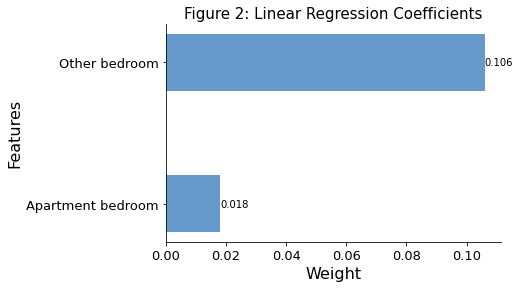

In [113]:
xcol = ["Apartment_bedroom", "Other_bedroom"]
model1 = Pipeline([
            ("lr", LinearRegression())
        ])
model1.fit(result[xcol], result["Total_K-12_block"])

idx = [t.replace("_", " ") for t in xcol]
fig, ax = plt.subplots()

ax3 = ax.barh(range(len(idx)), model1["lr"].coef_, color='#6699CC', height = 0.4)
ax.tick_params(labelsize=13)
for rect in ax3:
    w = rect.get_width()
    ax.text(w, rect.get_y()+rect.get_height()/2,
            "%.3f" % w, ha='left', va='center')
ax.set_yticks(range(len(idx)))
ax.set_yticklabels(idx)
ax.set_xlabel("Weight", fontsize=16)
ax.set_ylabel("Features", fontsize=16)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.set_title("Figure 2: Linear Regression Coefficients", fontsize=15)
print(model1["lr"].coef_[1] / model1["lr"].coef_[0])

In [27]:
# adjust the k-12 estimation using the new model
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]
ratio = model1["lr"].coef_[1] / model1["lr"].coef_[0]
result["BlockTotal_for_calculate"] = result["Apartment_bedroom"] + ratio * result["Other_bedroom"]
estimator = result[["GEO_ID", "BlockTotal_for_calculate"]]
estimator_dict = dict(zip(estimator['GEO_ID'],estimator['BlockTotal_for_calculate']))
def estimate_K12(df):
    if df["PropertyUse"] not in ["2 Unit", "Single family", "3 To 7 Unit"]:
        return df["Total_K-12_block"] * df["Bedrooms"]/ estimator_dict[df["GEO_ID"]]
    if df["PropertyUse"] in ["2 Unit", "Single family", "3 To 7 Unit"]:
        return df["Total_K-12_block"] * df["Bedrooms"]/ estimator_dict[df["GEO_ID"]] * ratio


K12_df["K12_est"] = K12_df.apply(lambda  r:estimate_K12(r), axis=1)
K12_df.head()

,Area,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,Total_people,Total_K-12_block,GEO_ID,area,BlockBedrooms,K12_est
0,"Block 2000, Block Group 2, Census Tract 6, Dan...",2218 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45969 43.02980),800982.301653,466465.530860,294,87,1000000US550250006002000,0.039495,354,5.898305
1,"Block 2000, Block Group 2, Census Tract 6, Dan...",2322 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45995 43.02816),800912.471326,465869.120662,294,87,1000000US550250006002000,0.039495,354,5.898305
2,"Block 2000, Block Group 2, Census Tract 6, Dan...",2306 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45986 43.02871),800935.774665,466068.197512,294,87,1000000US550250006002000,0.039495,354,5.898305
3,"Block 2000, Block Group 2, Census Tract 6, Dan...",2226 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45973 43.02952),800970.644487,466366.051694,294,87,1000000US550250006002000,0.039495,354,5.898305
4,"Block 2000, Block Group 2, Census Tract 6, Dan...",2234 Allied Dr,8 unit Apartment,Commercial,24,POINT (-89.45978 43.02925),800959.021351,466267.246640,294,87,1000000US550250006002000,0.039495,354,5.898305


## Top 50 apartments table

In [28]:
# sort by the number of K-12 children estimation grouped by Point.
K12_df["K-12_by_point"] = K12_df.groupby(by=["XCoord", "YCoord"])["K12_est"].transform('sum')
point_order = K12_df.sort_values(by=['K-12_by_point'], ascending=False)

In [29]:
Top_50 = K12_df
Top_50 = Top_50[Top_50["PropertyUse"] != "2 Unit"]
Top_50 = Top_50[Top_50["PropertyUse"] != "Single family"]
Top_50 = Top_50[Top_50["PropertyUse"] != "3 To 7 Unit"]
Top_50["Apartment_bedrooms"] = Top_50.groupby(["XCoord", "YCoord"]).Bedrooms.transform(sum)
Top_50 = Top_50.drop_duplicates("geometry")
Top_50 = Top_50.sort_values(by=['K-12_by_point'], ascending=False)
Top_50 = Top_50[:50]
Top_50 = Top_50[["Area", "Address", "geometry", "Apartment_bedrooms", "K-12_by_point", "XCoord", "YCoord", "GEO_ID"]]
total_50 = Top_50[["Address", "Apartment_bedrooms", "K-12_by_point"]]
total_50.to_csv("Top50_Apartments.csv", index = False)
total_50.head()

,Address,Apartment_bedrooms,K-12_by_point
7828,225 N Thompson Dr,948,109.000000
134,2002 Elka Ln,216,65.275956
7979,57 Northridge Ter,144,58.381935
4559,501 Northport Dr,384,58.000000
57647,312 East Bluff,441,43.404057


In [31]:
Top_50 = Top_50.reset_index()
Top_50 = Top_50[["Address", "GEO_ID", "Apartment_bedrooms", "K-12_by_point", "geometry"]]

In [32]:
Top_50.iloc[49]

Address                                          7502 Westward Way
GEO_ID                                    1000000US550250002043011
Apartment_bedrooms                                              96
K-12_by_point                                            15.692308
geometry              POINT (-89.51345156283065 43.06155116160458)
Name: 49, dtype: object

In [135]:
pd.set_option('display.max_rows', None)
block_with_apartment[block_with_apartment["GEO_ID"] == "1000000US550250024021020"]

,Address,PropertyUse,PropertyClass,Bedrooms,geometry,XCoord,YCoord,GEO_ID,area
18102,3702 Packers Ave,64 unit Apartment,Commercial,128,POINT (-89.35580 43.13358),828733.630900,504299.793036,1000000US550250024021020,0.015539
745,3709 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35633 43.13435),828591.802845,504578.930153,1000000US550250024021020,0.015539
9826,3613 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35632 43.13371),828595.271374,504346.037142,1000000US550250024021020,0.015539
21141,2001 Tennyson Ln,4 unit Apartment,Residential,8,POINT (-89.35633 43.13455),828590.364613,504651.634752,1000000US550250024021020,0.015539
31260,3701 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35632 43.13392),828594.178064,504423.195454,1000000US550250024021020,0.015539
47848,3605 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35631 43.13328),828597.321007,504191.087582,1000000US550250024021020,0.015539
51383,3705 Kipling Dr,4 unit Apartment,Residential,8,POINT (-89.35633 43.13413),828592.771616,504500.823327,1000000US550250024021020,0.015539
60574,3710 Packers Ave Unit 101,Condominium,Residential,1,POINT (-89.35581 43.13442),828729.074564,504604.243671,1000000US550250024021020,0.015539
60575,3710 Packers Ave Unit 103,Condominium,Residential,1,POINT (-89.35581 43.13442),828729.074564,504604.243671,1000000US550250024021020,0.015539
60576,3710 Packers Ave Unit 102,Condominium,Residential,2,POINT (-89.35581 43.13442),828729.074564,504604.243671,1000000US550250024021020,0.015539


## Plots

#### cumulative children live in apartments

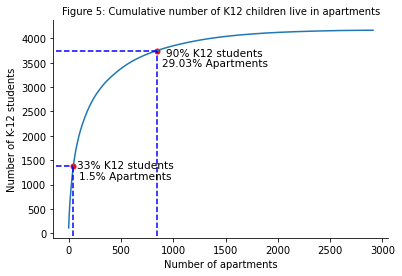

In [63]:
Buildings = K12_df[["GEO_ID", "PropertyUse", "geometry", "Area", "K-12_by_point"]]
Buildings = Buildings[Buildings["PropertyUse"] != "2 Unit"]
Buildings = Buildings[Buildings["PropertyUse"] != "Single family"]
Buildings = Buildings[Buildings["PropertyUse"] != "3 To 7 Unit"]
Buildings = Buildings.drop_duplicates("geometry")
Buildings = Buildings.sort_values(by=['K-12_by_point'], ascending=False)
K12_data = np.array(Buildings["K-12_by_point"].tolist())
cumulative = pd.DataFrame(K12_data.cumsum())
plt.plot(cumulative)
plt.axis('tight')
plt.title("Figure 5: Cumulative number of K12 children live in apartments", fontsize=10)
plt.xlabel("Number of apartments")
plt.ylabel("Number of K-12 students")
x_50 = 45.5
y_50 = 1389
plt.scatter(x_50, y_50, s=25, c='r')
plt.plot([-120, x_50], [y_50, y_50], c='b', linestyle='--')
plt.plot([x_50, x_50], [-50, y_50], c='b', linestyle='--')
plt.text(x_50+500, y_50-100, '33% K12 students', ha='center', va='bottom', fontsize=10.5)  # horizontal alignment
plt.text(x_50+500, y_50-320, '1.5% Apartments', ha='center', va='bottom', fontsize=10.5)

x_90 = 845
y_90 = 3750.3
plt.scatter(x_90, y_90, s=25, c='r')
plt.plot([-120, x_90], [y_90, y_90], c='b', linestyle='--')
plt.plot([x_90, x_90], [-50, y_90], c='b', linestyle='--')
plt.text(x_90+550, y_90-150, '90% K12 students', ha='center', va='bottom', fontsize=10.5)  # horizontal alignment
plt.text(x_90+550, y_90-370, '29.03% Apartments', ha='center', va='bottom', fontsize=10.5)
ax = plt.gca()
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
plt.show()

In [62]:
cumulative[0]

0        109.000000
1        174.275956
2        232.657890
3        290.657890
4        334.061947
           ...     
2907    4167.347792
2908    4167.347792
2909    4167.347792
2910    4167.347792
2911    4167.347792
Name: 0, Length: 2912, dtype: float64

## Use the linear regression coef to improve the estimate


In [35]:
total = model1["lr"].coef_[0] + model1["lr"].coef_[1]
apt_pro = model1["lr"].coef_[0]
house_pro = model1["lr"].coef_[1]

result["K12_in_apt"] = result["Total_K-12_block"] / (result["Other_bedroom"] + result["Apartment_bedroom"] * (apt_pro/house_pro)) * (result["Apartment_bedroom"] * (apt_pro/house_pro))
result["K12_in_other"] = result["Total_K-12_block"] - result["K12_in_apt"]
result['apt_density'] = result['K12_in_apt'] / result['area']
result['other_density'] = result['K12_in_other'] / result['area']
result.head()

,GEO_ID,BlockBedrooms,Total_K-12_block,geometry,area,Apartment_bedroom,Other_bedroom,BlockTotal_for_calculate,K12_in_apt,K12_in_other,apt_density,other_density
0,1000000US550250006002000,354,87,POINT (-89.45969 43.02980),0.039495,354.0,0.0,354.00000,87.000000,0.000000,2202.819568,0.000000
1,1000000US550250006002001,228,14,POINT (-89.45839 43.02956),0.016105,228.0,0.0,228.00000,14.000000,0.000000,869.268541,0.000000
2,1000000US550250005044020,180,9,POINT (-89.53268 43.02574),0.020012,128.0,52.0,431.52626,2.669594,6.330406,133.399554,316.330216
3,1000000US550250026032068,306,32,POINT (-89.29742 43.10858),0.009523,306.0,0.0,306.00000,32.000000,0.000000,3360.385726,0.000000
4,1000000US550250026032059,172,19,POINT (-89.29836 43.11047),0.017940,172.0,0.0,172.00000,19.000000,0.000000,1059.111662,0.000000


In [36]:
lake_df = gpd.read_file("lakes.zip")

### The density plot of k12 in apartment

Text(0.5, 1.0, 'Figure 4: Number of K-12 students living in apartments per square mile in each block')

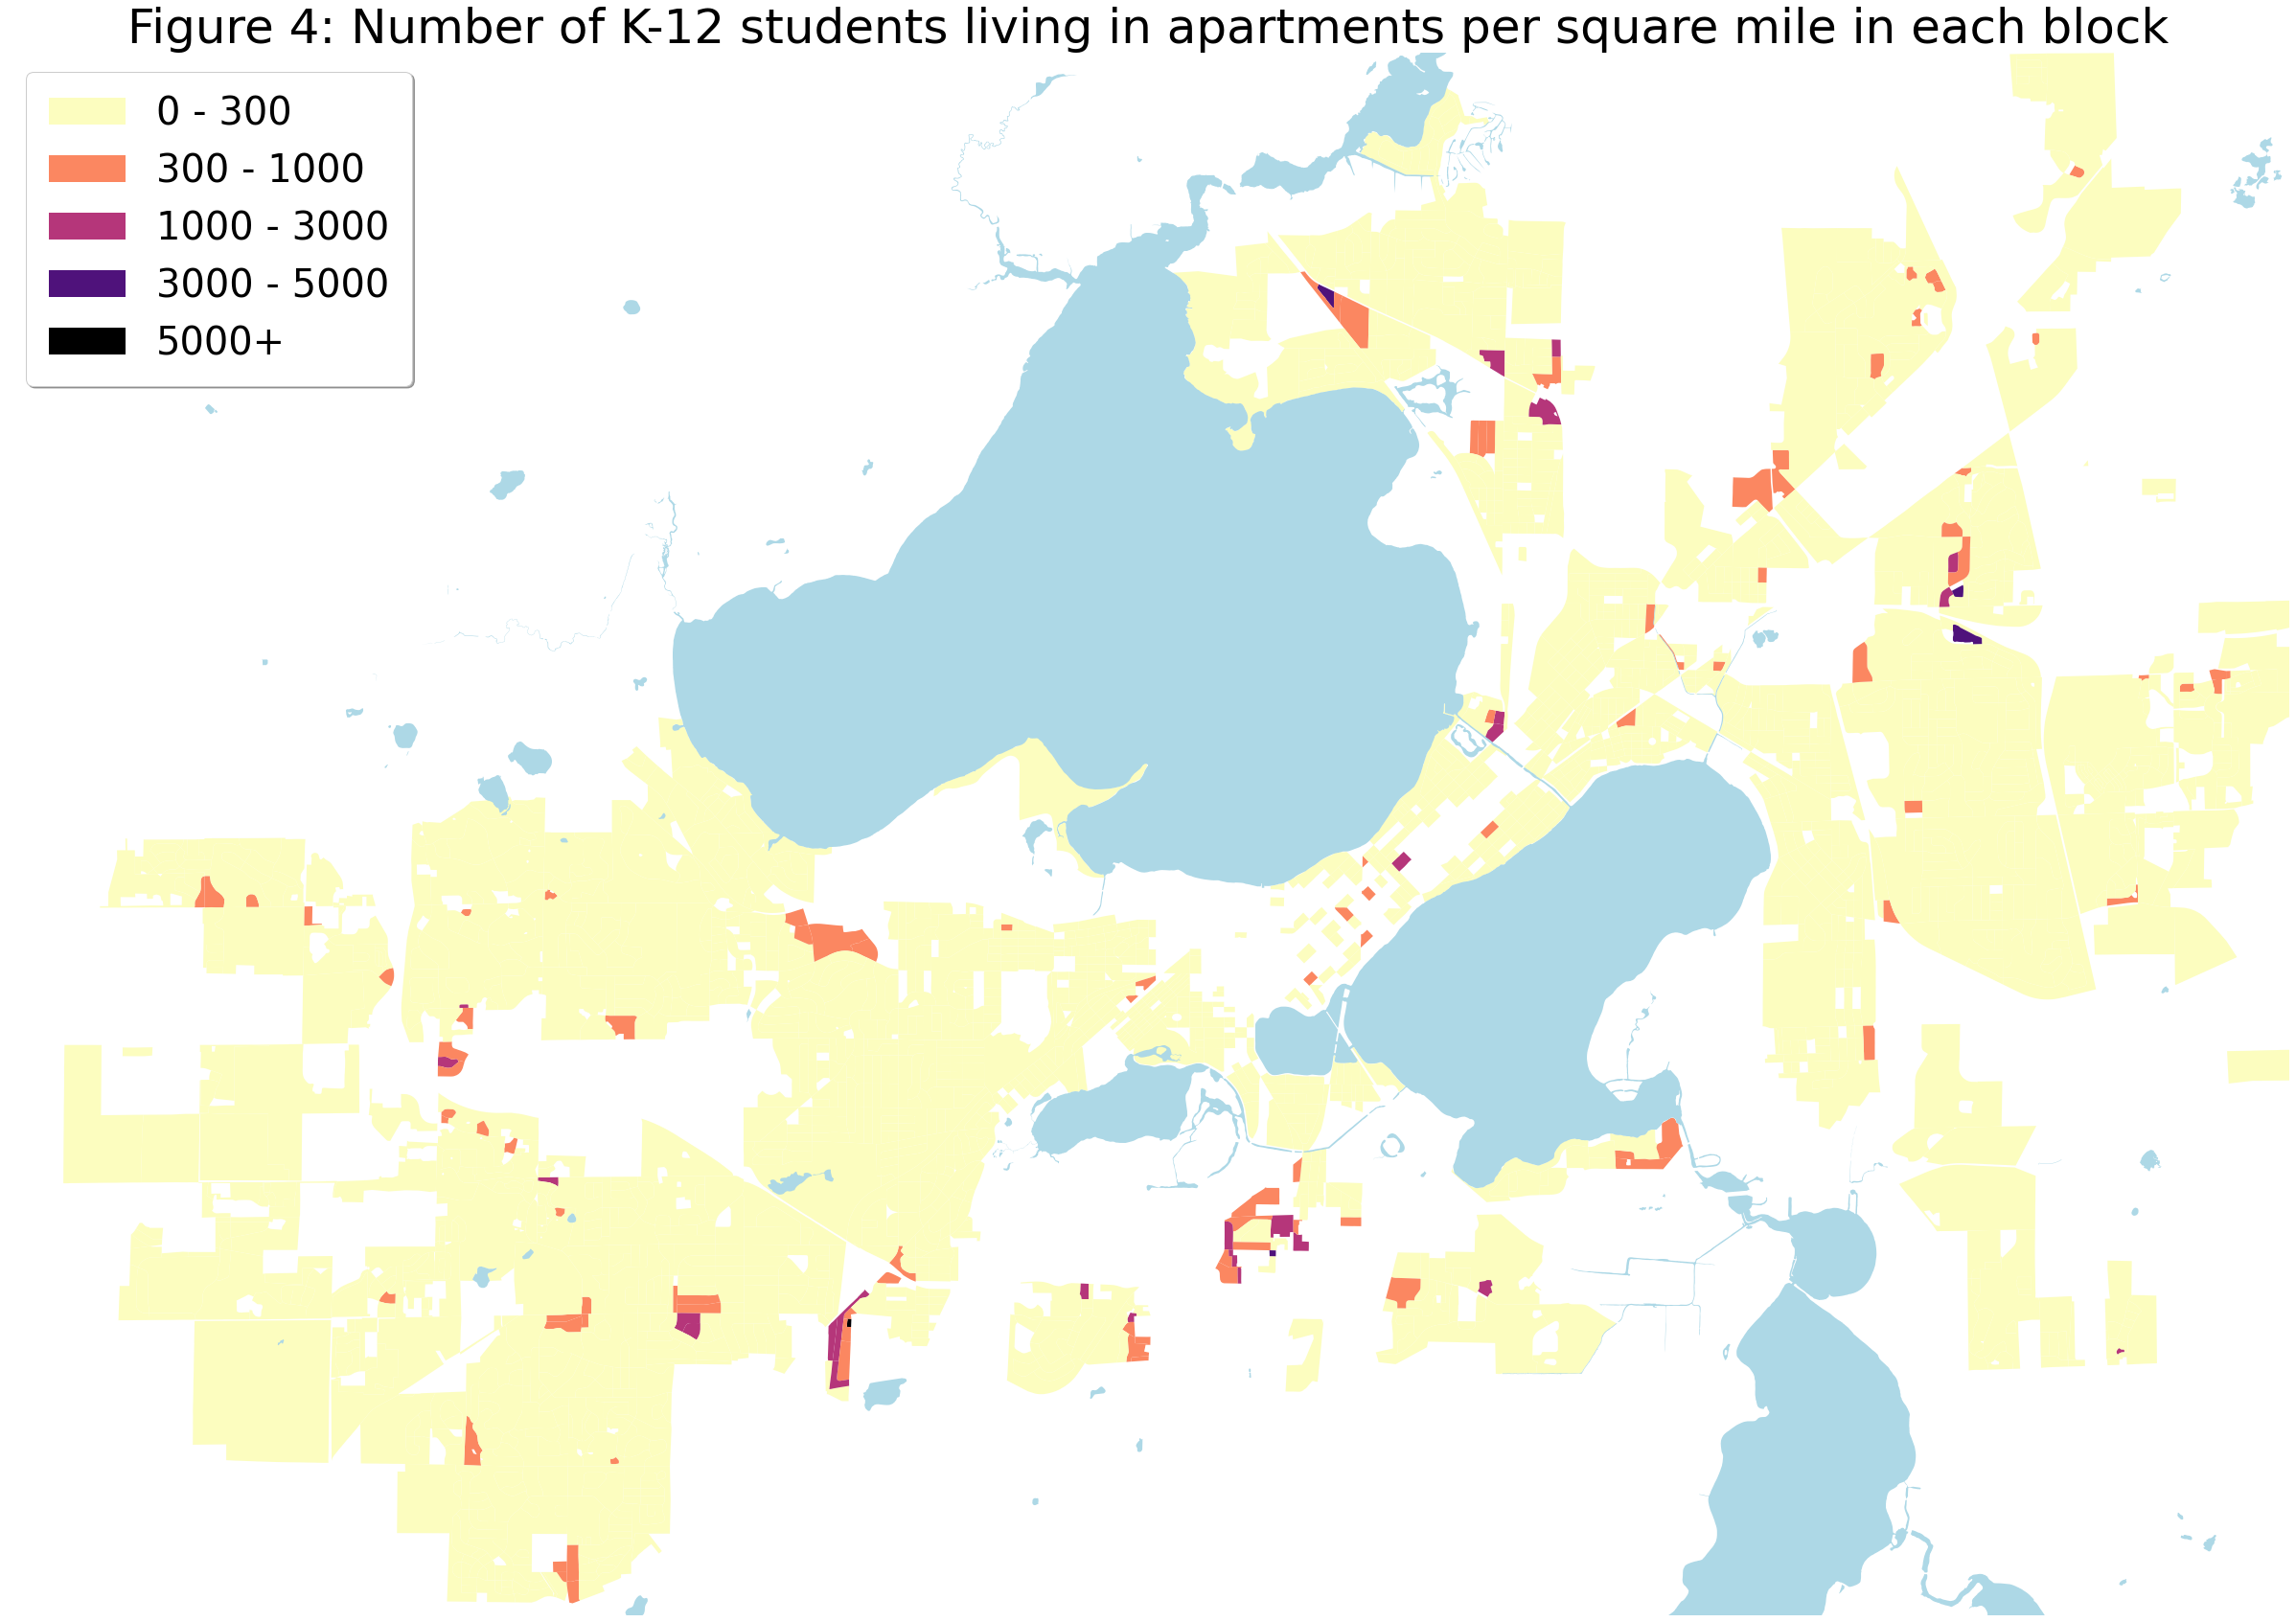

In [37]:
result = gpd.GeoDataFrame(result)
lake_df = lake_df.to_crs(result.crs)
apartment_madison = gpd.sjoin(result, dane, how="right", op="within")
apartment_madison = apartment_madison[["geometry", "apt_density"]]
apartment_madison = apartment_madison.dropna()

bp = mc.UserDefined(apartment_madison["apt_density"], bins=[300, 1000, 3000, 5000, 50000])
ax = apartment_madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [300, 1000, 3000, 5000, 50000]}, k = 5, column='apt_density', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')

bins = bp.bins
bins = np.insert(bins, 0, 0)
bp
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='5000+')]

ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
ax.axis('off')
ax.set_title("Figure 4: Number of K-12 students living in apartments per square mile in each block", fontsize = 50)

### The density plot of k12 in other house

Text(0.5, 1.0, 'Figure 3: Number of K-12 students living in houses per square mile in each block')

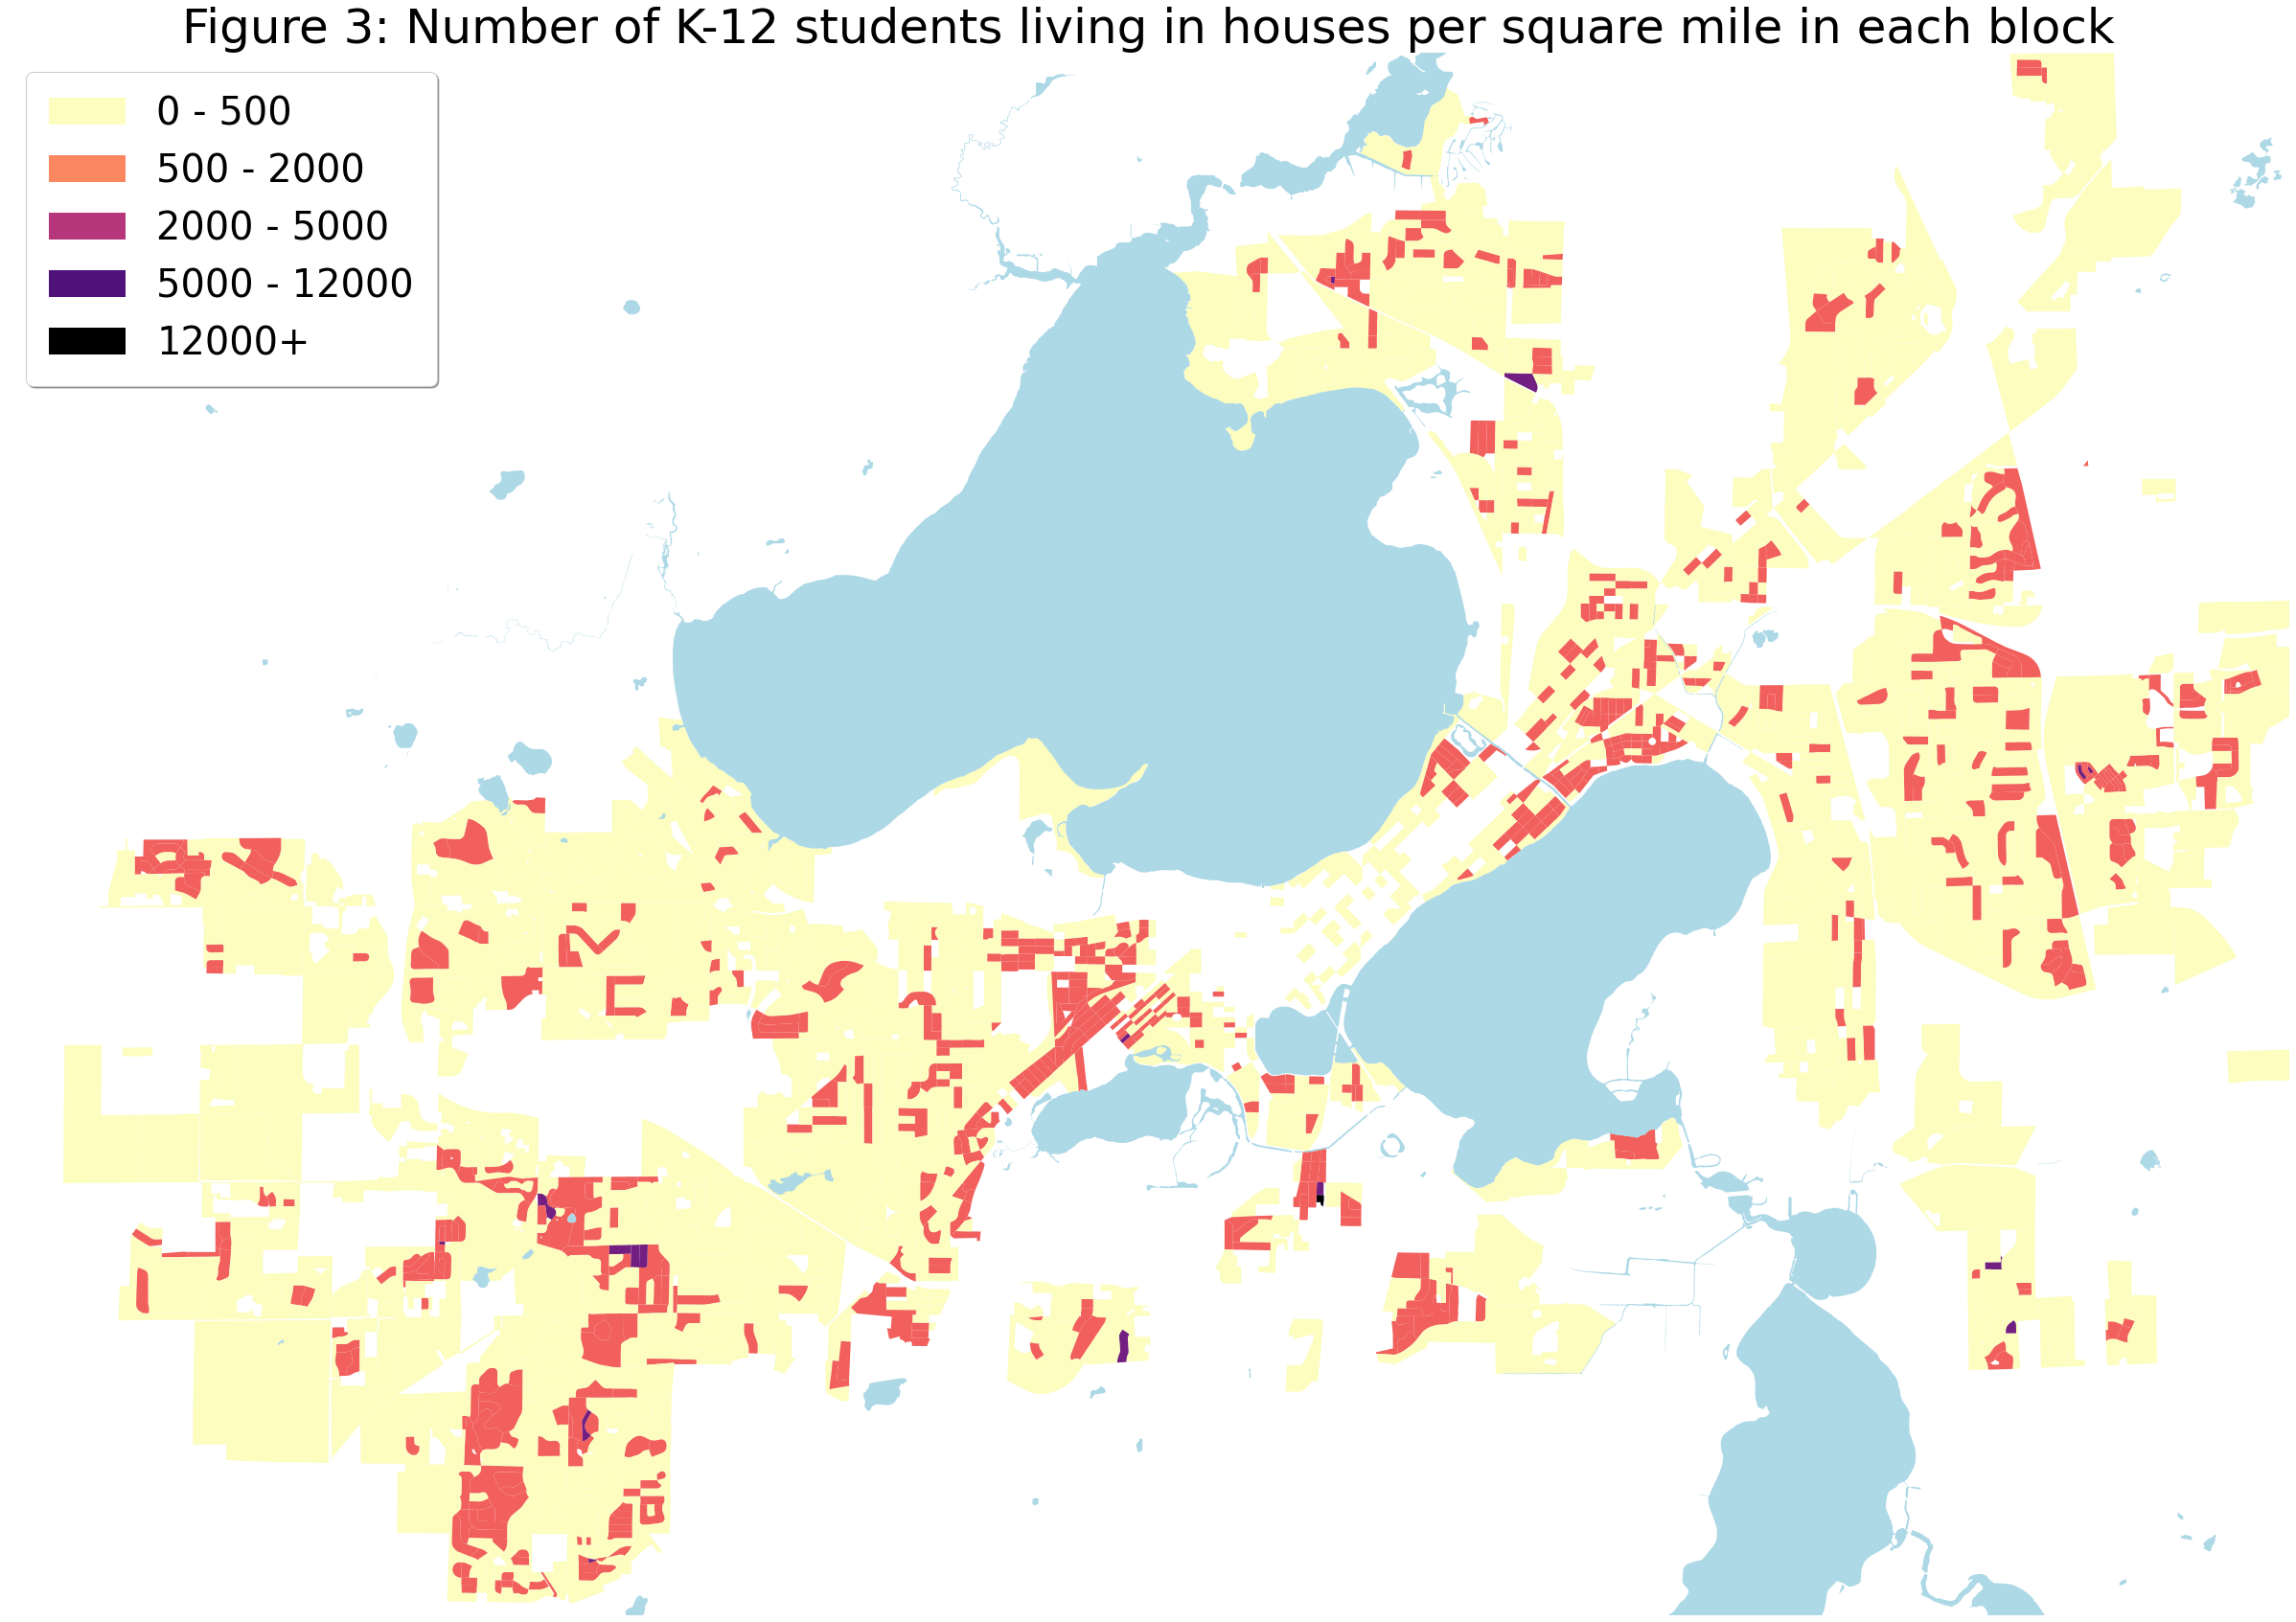

In [38]:
result = gpd.GeoDataFrame(result)
house_madison = gpd.sjoin(result, dane, how="right", op="within")
house_madison = house_madison[["geometry", "other_density"]]
house_madison = house_madison.dropna()
bp = mc.UserDefined(apartment_madison["apt_density"], bins=[500, 2000, 5000, 12000, 50000])
ax = house_madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [500, 2000, 5000, 12000, 50000]}, k = 5, column='other_density', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='12000+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
ax.axis('off')
ax.set_title("Figure 3: Number of K-12 students living in houses per square mile in each block", fontsize = 50)

## The density plot of k12 in each blocks

Text(0.5, 1.0, 'Figure 1: Number of K-12 students in Madison per block per square mile')

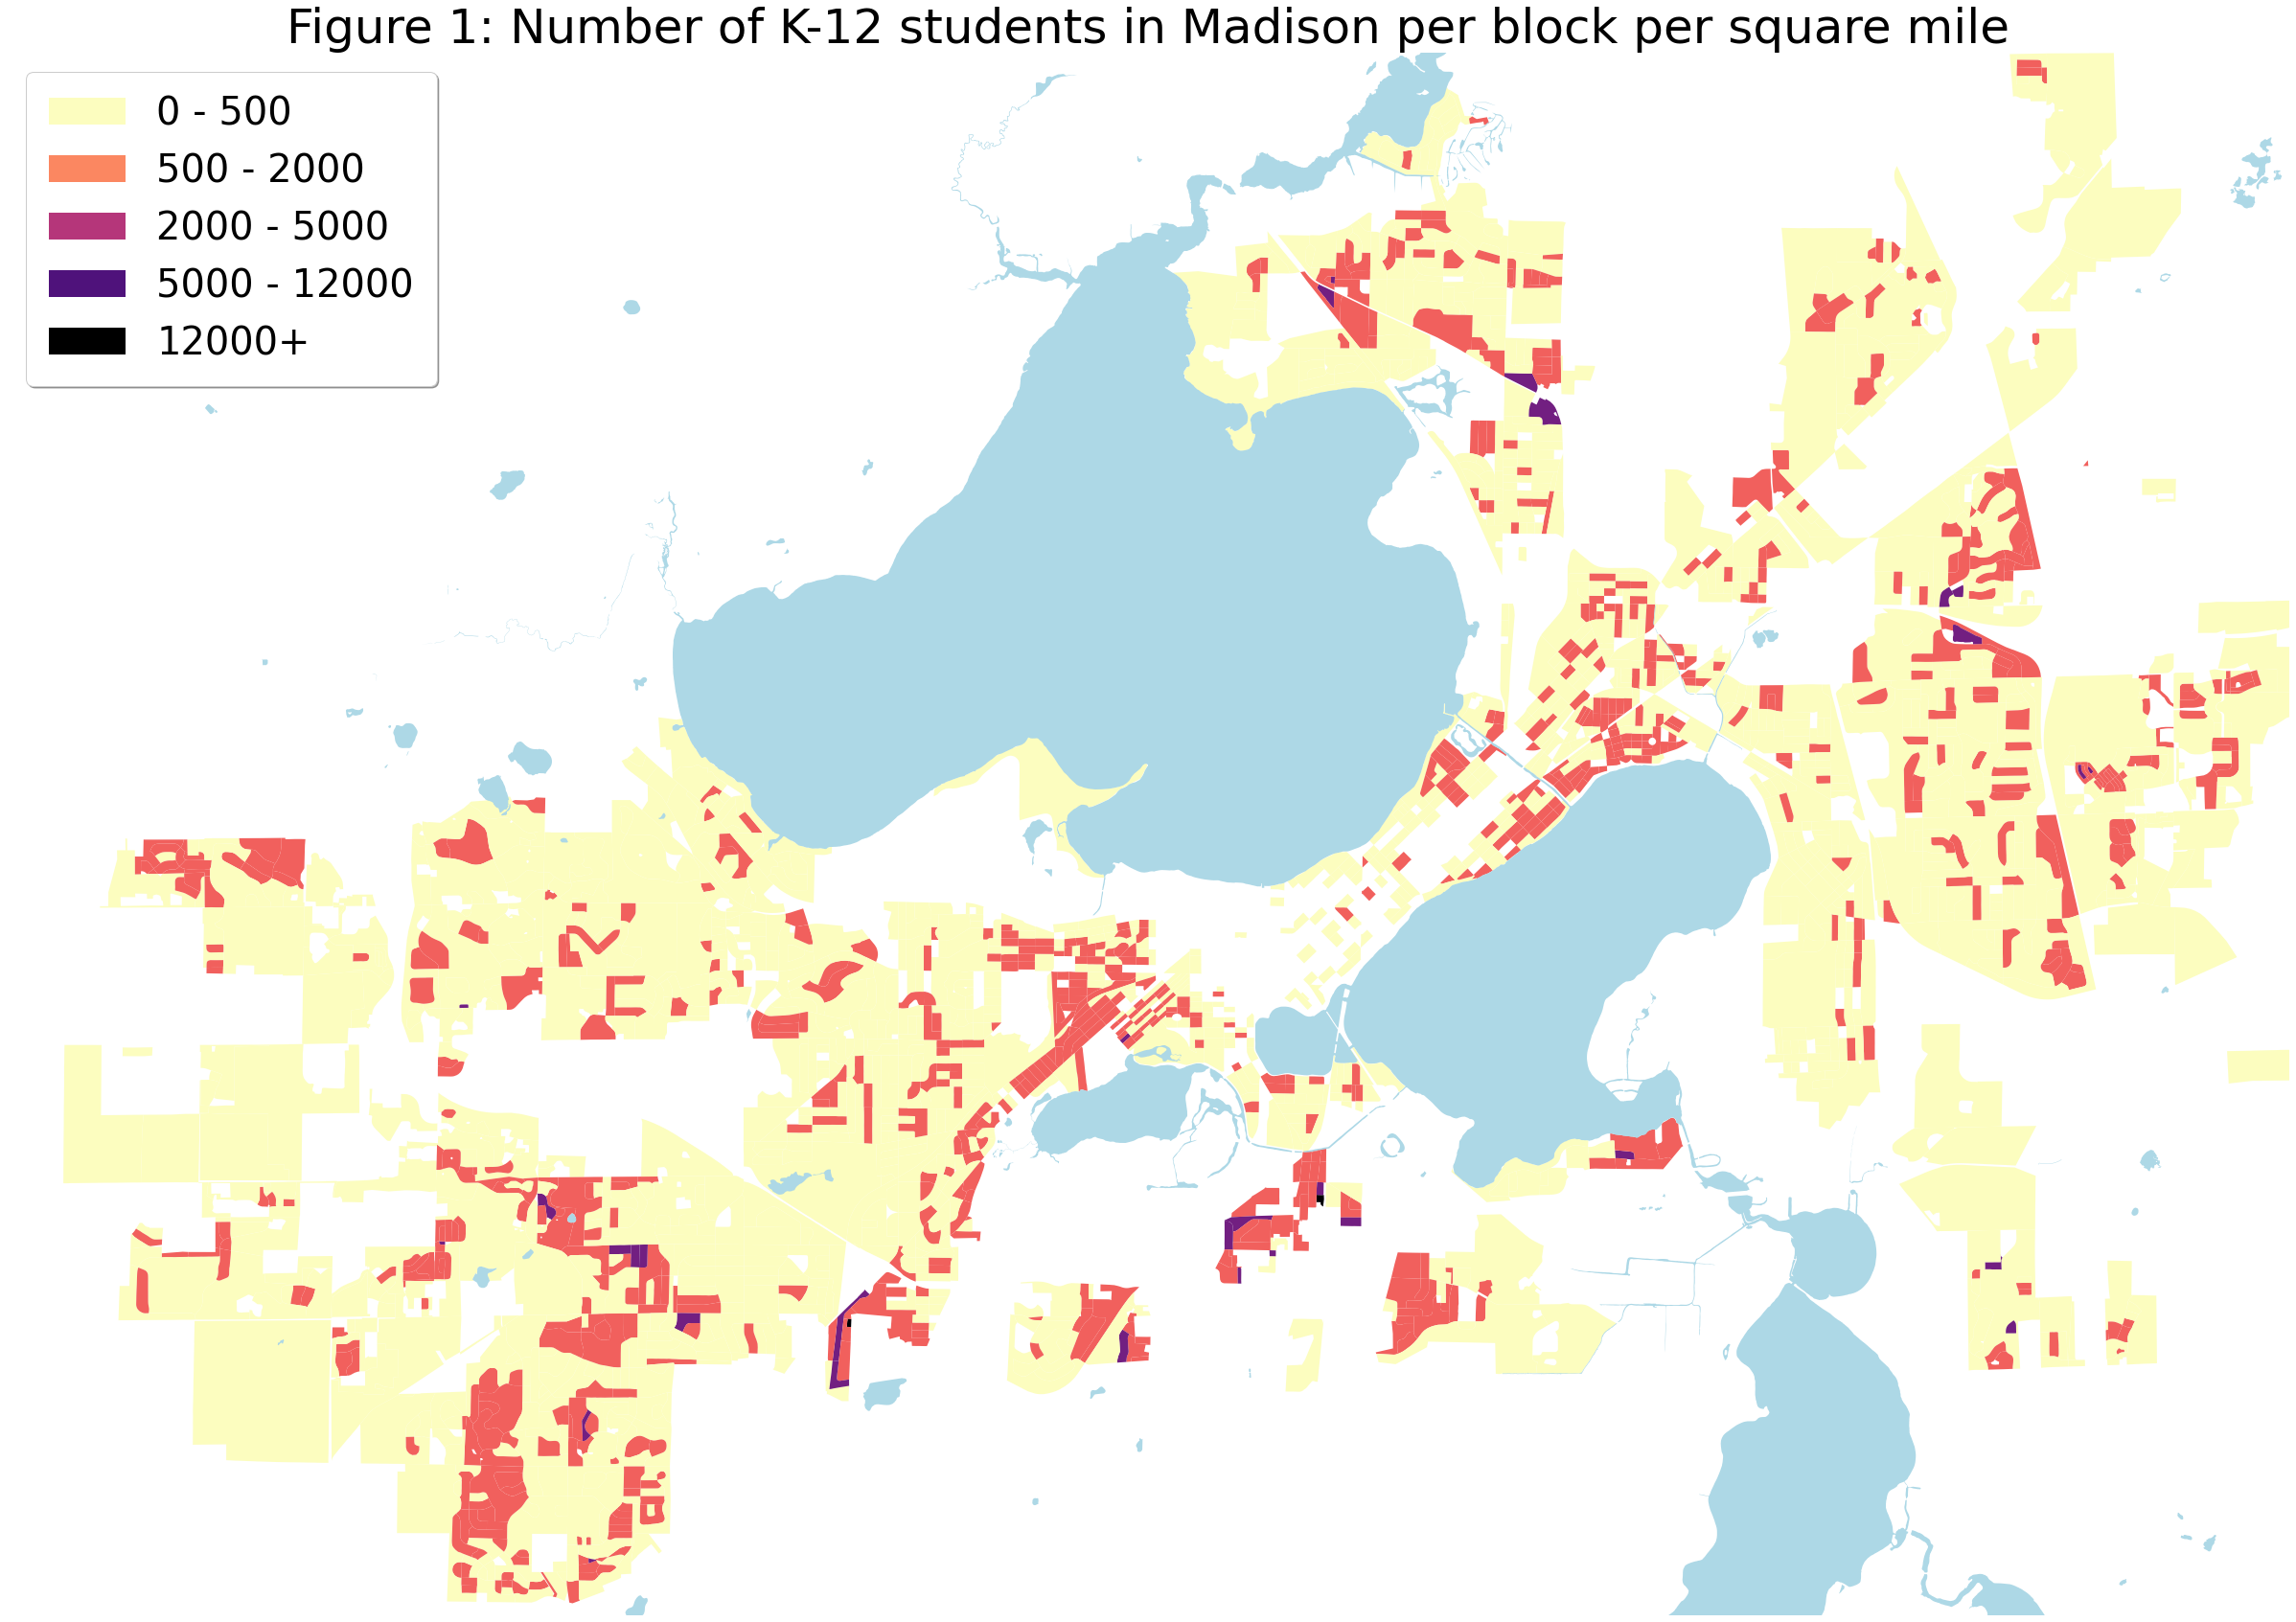

In [39]:
result["block_density"] = result['Total_K-12_block'] / result['area']
result = gpd.GeoDataFrame(result)
madison = gpd.sjoin(result, dane, how="right", op="within")
madison = madison[["geometry", "block_density"]]
madison = madison.dropna()
bp = mc.UserDefined(apartment_madison["apt_density"], bins=[500, 2000, 5000, 12000, 50000])
ax = madison.plot(figsize = (50, 30), legend=True, scheme = 'UserDefined',
                  classification_kwds={'bins': [500, 2000, 5000, 12000, 50000]}, k = 5, column='block_density', cmap = 'magma_r')
handles, labels = ax.get_legend_handles_labels()
cmap = plt.get_cmap('magma_r')
bins = bp.bins
bins = np.insert(bins, 0, 0)
LegendElement = [mpatches.Patch(facecolor=cmap(_*0.25), label=f'{int(max(bins[_], 0))} - {int(bins[_+1])}')
                 for _ in range(4)] + [mpatches.Patch(facecolor='black', hatch='', label='12000+')]
ax.legend(handles = LegendElement, loc='upper left', fontsize=40, shadow=True, borderpad=0.6)
lake_df.plot(ax=ax,color="lightblue")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_ylim([43.000, 43.165])
ax.set_xlim([-89.58, -89.25])
ax.axis('off')
ax.set_title("Figure 1: Number of K-12 students in Madison per block per square mile", fontsize = 50)